<a href="https://colab.research.google.com/github/mayhd3/NSF-REU-2021/blob/main/AMIvisualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd

if not os.path.exists('SM-30.csv'):
  !gdown --id 1UnP8x_WQ-Aroq8Rz4C1NUSEG9Iul1y7r

sm30 = pd.read_csv('SM-30.csv', header=None)
print(sm30)

        0         1          2   ...          48          49          50
0        1  20160101     Friday  ...   51.175717  143.252283  137.462967
1        1  20160102   Saturday  ...   69.247467   34.006950   13.018783
2        1  20160103     Sunday  ...   87.413983   34.309583    8.045783
3        1  20160104     Monday  ...   57.762917   59.193917   84.350667
4        1  20160105    Tuesday  ...   99.809000   37.494800   62.593817
...    ...       ...        ...  ...         ...         ...         ...
39781  114  20161210   Saturday  ...  103.174867  105.520250   99.261717
39782  114  20161211     Sunday  ...   78.534017   55.942400   61.001317
39783  114  20161212     Monday  ...   94.071350   39.962617   71.267533
39784  114  20161213    Tuesday  ...  114.110617   71.144167   66.459417
39785  114  20161214  Wednesday  ...   80.857933   60.401817   68.659183

[39786 rows x 51 columns]


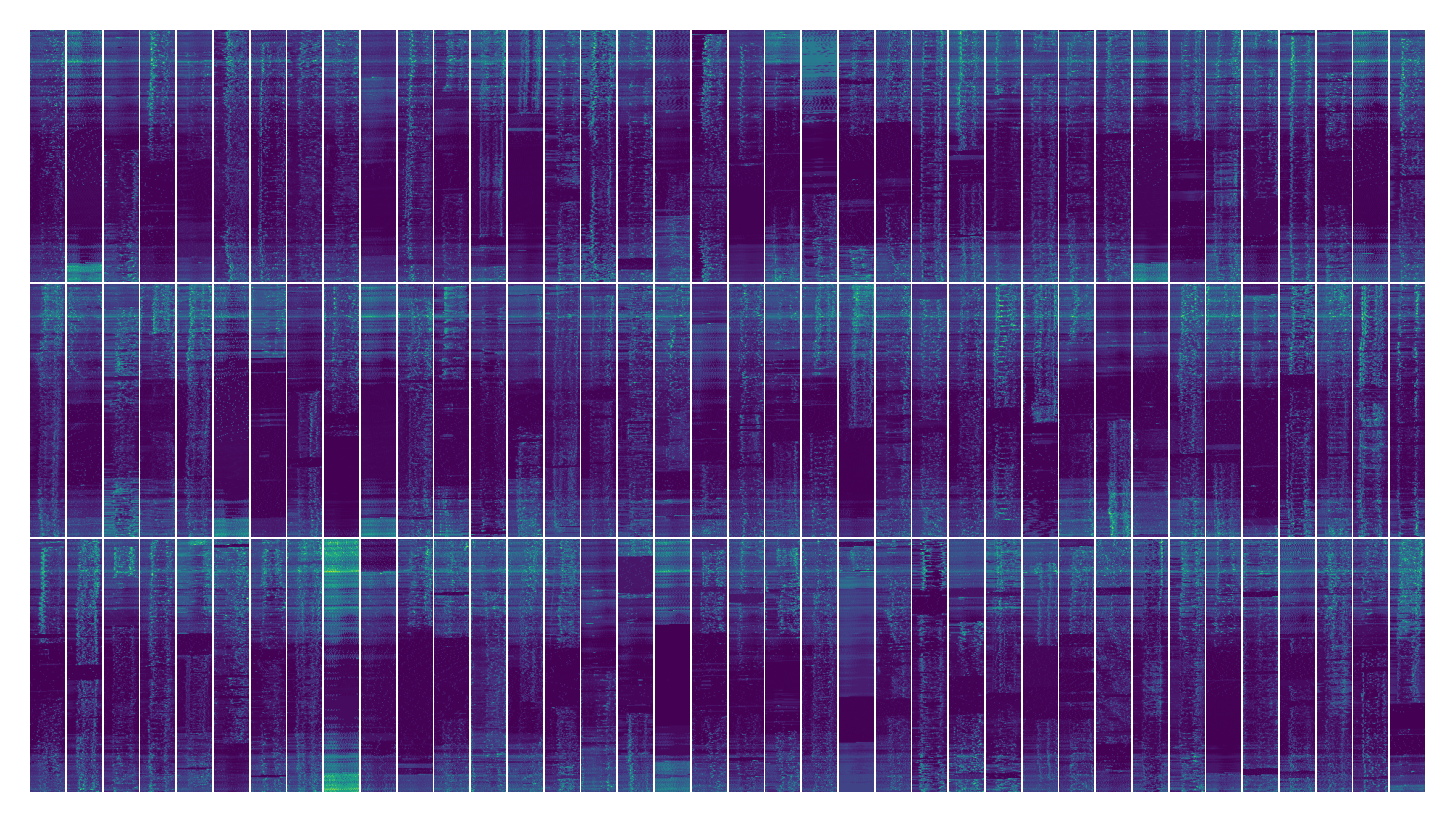

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

reals = np.split(
    sm30.iloc[:,3:].to_numpy(),
    sm30[0].diff()[1:].to_numpy().nonzero()[0] + 1
)

def heatmap(data):
  ig = ImageGrid(plt.gcf(), 111, nrows_ncols=(3, 38), axes_pad=2/300, direction='column')

  for ax,im in zip(ig,data):
    ax.set_axis_off()
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.imshow(im)

plt.figure(dpi=300)
heatmap(reals)

In [4]:
import ipywidgets as ipw
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.colors as mcolors

out1 = ipw.Output()

def plot_with_acf(out, data, index, starts=None):
  colors = list(mcolors.TABLEAU_COLORS.values())
  color = colors[index%len(colors)]

  if 0 <= index < len(data):
    flat = data[index].flatten()

    out.clear_output()
    with out:
      fig1 = plt.figure(dpi=100)
      plt.title("Meter " + str(index))
      plt.plot(flat, c=color)
      if starts is not None:
        plt.axvline(starts[index] * len(data[index][0]), c='r')

      fig2 = plt.figure(dpi=100)
      plot_acf(flat, ax=plt.gca(), lags=np.arange(len(flat))[::500], c=color)
      if starts is not None:
        plt.axvline(starts[index] * len(data[index][0]), c='r')

      plt.show()
      return fig1, fig2

it1 = ipw.IntText(
  value=0,
  description='Meter to plot:',
  style={'description_width': 'initial'}
)

it1.observe(lambda event: plot_with_acf(out1, reals, event['new']), names='value')
plot_with_acf(out1, reals, it1.value)

display(it1, out1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


IntText(value=0, description='Meter to plot:', style=DescriptionStyle(description_width='initial'))

Output()

In [5]:
out3 = ipw.Output()

for index in range(len(reals)):
  if not os.path.exists('acf/'):
    os.mkdir('acf/')
  path1, path2 = 'acf/'+str(index)+'.png', 'acf/'+str(index)+'_acf.png'
  exists1, exists2 = os.path.exists(path1), os.path.exists(path2)
  if not exists1 or not exists2:
    fig1, fig2 = plot_with_acf(out3, reals, index)
    if not exists1:
      fig1.savefig(path1)
    if not exists2:
      fig2.savefig(path2)

if not os.path.exists('acf.zip'):
  !zip -r acf.zip acf/

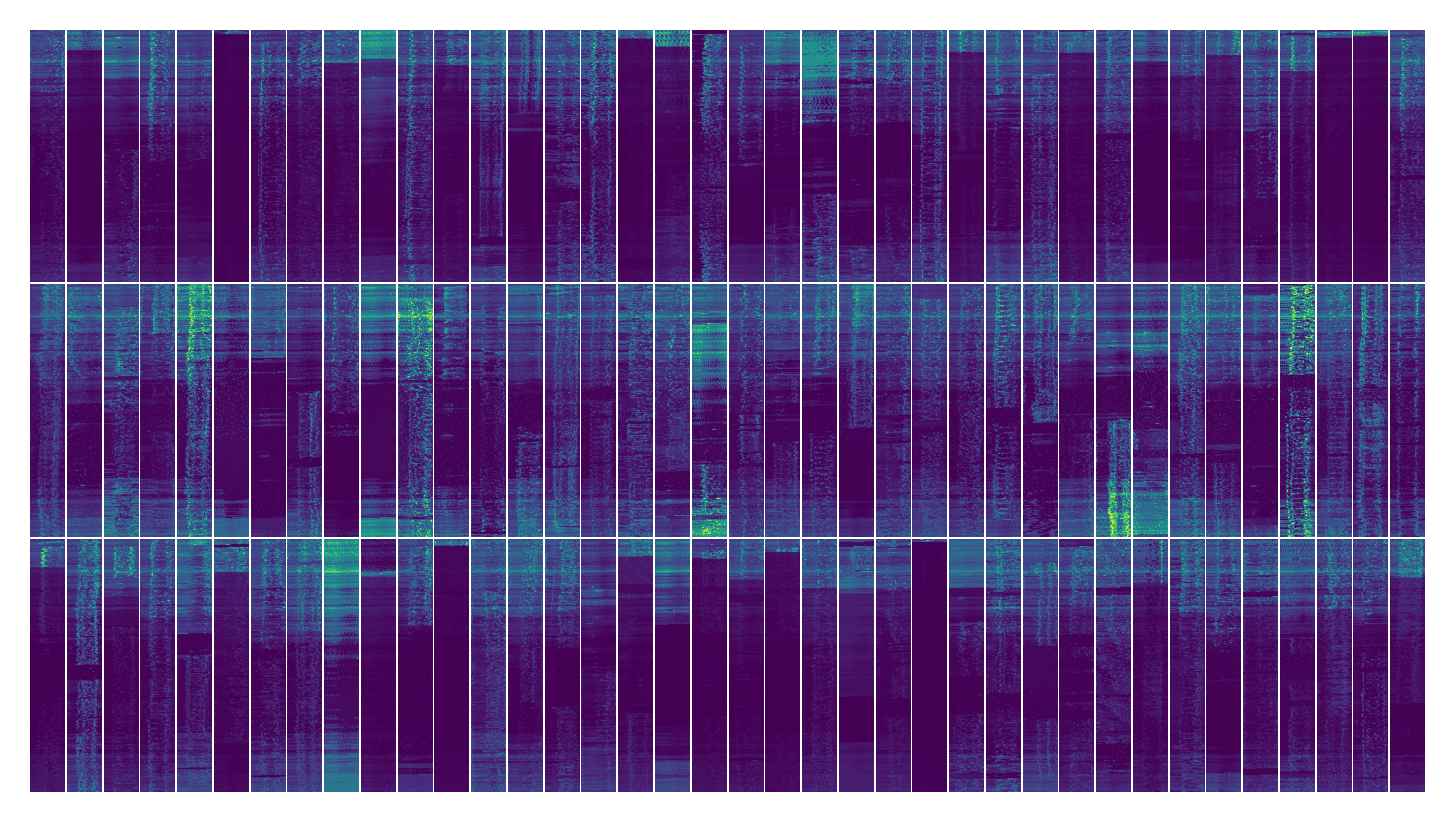

In [6]:
from copy import deepcopy

# simulate energy theft by scaling samples down, clipping them to a max, or both
fakes = deepcopy(reals)

# each sample will have a different starting date
linear = np.linspace(0,1,num=len(fakes),endpoint=False)
np.random.shuffle(linear)
starts = np.multiply(linear, [len(fake)/2 for fake in fakes]).astype(int)

for i in range(len(fakes)):
  # theft starts at most half way through the year
  start = starts[i]

  if (i%3) != 1:
    for j in range(start,len(fakes[i])):
      fakes[i][j] *= linear[i]

  if (i%3) != 0:
    # clip max to somewhere between the first and third quartile
    min, max = np.amin(fakes[i][start:]), np.amax(fakes[i][start:])
    lerp = linear[(i+1)%len(linear)]
    clip = (max+min)*.5 + (max-min)*.25*(lerp-.5)
    for j in range(start,len(fakes[i])):
      fakes[i][j] = np.clip(fakes[i][j],0,clip) 

plt.figure(dpi=300)
heatmap(fakes)

In [7]:
out2 = ipw.Output()

it2 = ipw.IntText(
  value=0,
  description='Fake meter to plot:',
  style={'description_width': 'initial'}
)

it2.observe(
  lambda event: plot_with_acf(out2, fakes, event['new'], starts),
  names='value'
)

plot_with_acf(out2, fakes, it2.value, starts)

display(it2, out2)

IntText(value=0, description='Fake meter to plot:', style=DescriptionStyle(description_width='initial'))

Output()

In [8]:
import pickle

# sanity check, fake data shows lower power consumption than the real data
assert(np.less_equal(fakes,reals).all())

# make a similar dataframe with the shuffled fake data
shuffle = np.random.permutation(len(fakes))
sm30f = pd.DataFrame(np.column_stack((
  sm30[range(3)],
  np.concatenate(np.take(fakes, shuffle, axis=0))
)))

# mask the interval that covers where our fake readings begin
sm30f = sm30f.shift(axis='columns')
for i in shuffle:
  index = sm30f[sm30f[1] == i+1].index
  start = index[0] + starts[i]
  sm30f[0][range(index[0], start)] = 0
  sm30f[0][range(start, index[-1]+1)] = 1

# label which kind of fake data is in each row
sm30f = sm30f.shift(axis='columns')
sm30f[0] = np.take(shuffle, sm30f[2] - 1) % 3 + 1
sm30f[2] += len(fakes)

# combine both dataframes to make our training and testing datasets
full = pd.concat((
  sm30.shift(axis='columns', periods=2, fill_value=0),
  sm30f
)).reset_index(drop=True)

print(full)
if not os.path.exists('full.pickle'):
  with open('full.pickle','wb') as pk:
    pickle.dump(full, pk)

       0  1    2         3   ...       47       48       49       50
0       0  0    1  20160101  ...  41.5937  37.2213  38.4995  51.1757
1       0  0    1  20160102  ...  77.3123  59.3962  58.4204  69.2475
2       0  0    1  20160103  ...  74.5085  62.4546   47.916   87.414
3       0  0    1  20160104  ...  57.2456  59.1451  72.3213  57.7629
4       0  0    1  20160105  ...  55.3683  66.2452  55.6019   99.809
...    .. ..  ...       ...  ...      ...      ...      ...      ...
79567   2  1  228  20161210  ...  76.1801   79.404  94.2175  76.1528
79568   2  1  228  20161211  ...  93.3697  57.1612  53.2939  56.7906
79569   2  1  228  20161212  ...  44.8726   40.422  66.0135  55.1194
79570   2  1  228  20161213  ...   49.493  57.6839  38.2715  60.2319
79571   2  1  228  20161214  ...  63.9341  53.6389  74.0242  52.0913

[79572 rows x 51 columns]


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.utils import np_utils
from scipy.signal import find_peaks

try:
  full
except NameError:
  if os.path.exists('full.pickle'):
    with open('full.pickle','rb') as pk:
      full = pickle.load(pk)

# group dataset by customer
groups = full.groupby(2)
meters = [groups.get_group(group) for group in groups.groups]

# cnn input is a 2D array of semi hourly consumption by week
X0 = [meter.iloc[:,5:].to_numpy() for meter in meters]
y0 = [
  {0: [0,0], 1: [0,1], 2:[1,0], 3:[1,1]}[meter.iloc[0,0]]
    for meter in meters
]

# fnn input is a 1D array of consumption over the year
X1 = [x.flatten() for x in X0]
y1 = [meter[1].to_numpy() for meter in meters]

# rnn input is a time series between consumption minima and maxima
X2 = [np.diff(find_peaks(np.mean(x, axis=1))[0]) for x in X0]
y2 = [y != 0 for y in y0]

def bhwc(twod):
  return np.expand_dims(np.array(twod), axis=-1).astype('float32')

# partition training and testing datasets
def periodic_partition(array, ratio):
  return (
    [array[i] for i in range(len(array)) if i%ratio == 0],
    [array[i] for i in range(len(array)) if i%ratio != 0]
  )

X0_test, X0_train = (bhwc(X) for X in periodic_partition(X0, 3))
y0_test, y0_train = (np.array(y) for y in periodic_partition(y0, 3))

# cnn structure is (conv -> pool) x3 -> dropout -> dense x2
cnn = Sequential()
cnn.add(Conv2D(32, (3,3), input_shape=X0_train.shape[1:], activation='relu'))
#cnn.add(Conv2D(32,(4,4),input_shape=X0_train.shape, activation='relu'))
#cnn.add(MaxPool2D(pool_size=2))
#cnn.add(Conv2D(64,(26,26),activation='relu'))
#cnn.add(MaxPool2D(pool_size=2))
#cnn.add(Conv2D(128,(9,9),activation='relu'))
#cnn.add(MaxPool2D(pool_size=2))
#cnn.add(Dropout(0.0625))
cnn.add(Flatten())
#cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(2, activation='softmax'))

cnn.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

cnn.fit(
    X0_train,
    y0_train,
    epochs=52
#    batch_size=152,
#    verbose=2
)
cnn.evaluate(X0_test, y0_test, verbose=2)


Epoch 1/52
5/5 [==============================] - 2s 307ms/step - loss: 541.5698 - accuracy: 0.6155
Epoch 2/52
5/5 [==============================] - 2s 294ms/step - loss: 175.8364 - accuracy: 0.5849
Epoch 3/52
5/5 [==============================] - 2s 303ms/step - loss: 47.2856 - accuracy: 0.7117
Epoch 4/52
5/5 [==============================] - 1s 292ms/step - loss: 28.2411 - accuracy: 0.6931
Epoch 5/52
5/5 [==============================] - 2s 295ms/step - loss: 34.2330 - accuracy: 0.7546
Epoch 6/52
5/5 [==============================] - 1s 290ms/step - loss: 72.7560 - accuracy: 0.4287
Epoch 7/52
5/5 [==============================] - 1s 291ms/step - loss: 116.0566 - accuracy: 0.5004
Epoch 8/52
5/5 [==============================] - 1s 286ms/step - loss: 180.0514 - accuracy: 0.7862
Epoch 9/52
5/5 [==============================] - 1s 290ms/step - loss: 198.6078 - accuracy: 0.5927
Epoch 10/52
5/5 [==============================] - 2s 293ms/step - loss: 133.5865 - accuracy: 0.6533
Epo

[21054.10546875, 0.8947368264198303]